# Testing degradation on ABC vs true distribution

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

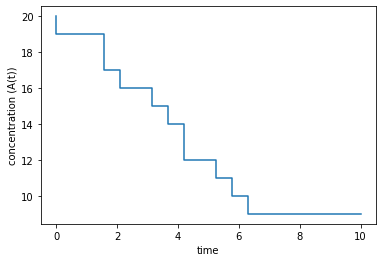

In [19]:
np.random.seed(1)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 20)

values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0], [0.3])

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

In [20]:
np.random.seed(0)

from math import comb

n_0 = 20

# Probability for one data point
def compute_prob(n, t, k):
    exp_term = np.exp(-k * n * t)
    comb_term = comb(n_0, int(n)) 
    t_term = (1 - np.exp(-k * t)) 
    return exp_term * comb_term * (t_term ** (n_0 - n))

# Probability for multiple data points
def prob_gen(data, times, k):
    all_prob = 1.0
    for i in range(len(data)):
        computed_prob = compute_prob(data[i][0], times[i], k)
        all_prob *= computed_prob
    return all_prob


# Compute integral
from scipy import integrate

func = lambda x : prob_gen(values, times, x)
int_val = integrate.quad(func, 0.01, 0.3)
print("likelihood integrate value="+str(int_val[0]))

# True posterior
def posterior(data, times, k):
    return prob_gen(data, times, k) / int_val[0]

thetas = np.linspace(0.01, 0.3, 30)
true_prob = []
for i in range(len(thetas)):
    true_prob.append(posterior(values, times, thetas[i]))

v_func = lambda x : posterior(values, times, x)
i_val = integrate.quad(v_func, 0.01, 0.3)

print("posterior integrate value="+str(i_val[0]))

likelihood integrate value=2.7564000797764155e-16
posterior integrate value=1.0001433014976961


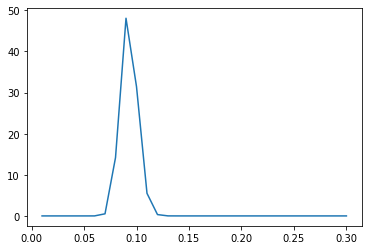

In [21]:
plt.plot(thetas, true_prob)
plt.show()

# Rejection ABC

In [22]:
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(0.85)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     239    0.00418410042    0:00.1
2     645    0.00310077519    0:00.2
3     776    0.00386597938    0:00.3
20    3533   0.00566091141    0:01.3
40    7315   0.00546821599    0:02.8
60    14070  0.00426439232    0:05.2
80    18100  0.0044198895     0:06.6
100   22855  0.00437541019    0:08.2
120   27613  0.00434577916    0:09.8
140   31292  0.00447398696    0:11.1
160   37009  0.00432327272    0:13.1
180   42611  0.00422426134    0:15.1
200   46936  0.00426112153    0:16.7
220   51224  0.00429486178    0:18.2
240   56198  0.00427061461    0:20.0
260   61731  0.00421182226    0:22.0
280   64911  0.00431359862    0:23.1
300   69981  0.00428687787    0:24.9
320   75412  0.00424335649    0:26.8
340   79167  0.00429471876    0:28.1
360   83079  0.004333225      0:29.6
380   87687  0.00433359563    0:31.2
400   93184  0.00429258242    0:33.1
420   96237  0.00436422582    0:34.1
440   102431  0.

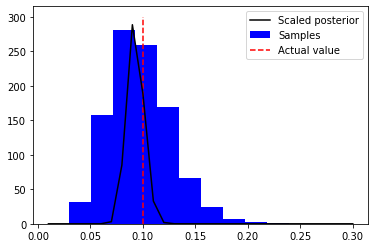

In [23]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
mod_true_prob = [x * 6 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

# PMC Degradation (with smc)

In [30]:
np.random.seed(0)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([1.2, 1, 0.8]))

# produce intermediate distributions of size 1000
abc.sampler().set_intermediate_size(1000)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=1.0
Trying t=2, threshold=0.8
Iter. Eval. Acceptance rate Time m:s
1     68407  1.4618387e-05    1:12.3
2     68907  2.90246274e-05   1:12.8
3     69287  4.32981656e-05   1:13.2
20    73824  0.000270914608   1:16.7
40    77526  0.000515955937   1:19.7
60    80460  0.000745712155   1:22.1
80    84055  0.000951757778   1:25.0
100   87542  0.00114230883    1:28.1
120   92565  0.00129638632    1:32.8
140   94296  0.00148468652    1:34.3
160   97526  0.00164058815    1:36.6
180   101370  0.00177567328    1:39.3
200   103832  0.00192618846    1:40.9
220   106989  0.00205628616    1:43.0
240   110646  0.00216907977    1:45.3
260   113418  0.00229240509    1:47.3
280   116692  0.00239947897    1:49.4
300   120056  0.00249883388    1:51.6
320   122725  0.00260745569    1:53.4
340   125840  0.00270184361    1:55.5
360   130505  0.002758515      1:58.5
380   135135  0.00281200281    2:01.5
400   138257  0.00289316273    2:03.5
420   

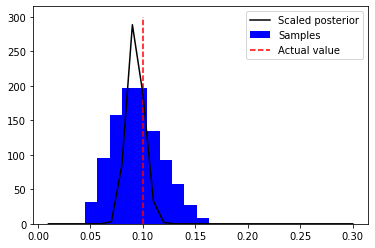

In [31]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
mod_true_prob = [x * 6 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

# True PMC

In [13]:
np.random.seed(3)

abc = pints.ABCController(error_measure, log_prior, method=pints.ABCPMC)

# set the threshold
abc.sampler().set_threshold(1)

# set target number of samples
# try this
abc.set_n_samples(500)

# setting the number of generations
abc.sampler().set_n_generations(20)

# setting the threshold ratio
abc.sampler().set_t_ratio(0.99)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using PMC ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     465899  0.00107534036   18:42.1
Halting: target number of samples (501) reached.
Done


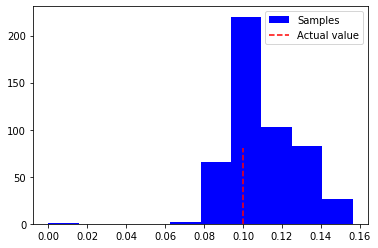

In [14]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=80, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

# ABC SMC

In [24]:
np.random.seed(0)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([1.2, 1, 0.8]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=1.0
Trying t=2, threshold=0.8
Iter. Eval. Acceptance rate Time m:s
1     15519  6.44371416e-05   0:07.9
2     15660  0.000127713921   0:08.0
3     15708  0.000190985485   0:08.0
20    19081  0.00104816309    0:09.8
40    21987  0.00181925683    0:11.5
60    24541  0.00244488815    0:12.9
80    26769  0.00298853151    0:14.2
100   29683  0.00336893171    0:15.9
120   33592  0.00357227911    0:18.0
140   36405  0.0038456256     0:19.5
160   38591  0.00414604441    0:20.7
180   41972  0.00428857333    0:22.5
200   44818  0.00446249275    0:24.2
220   47166  0.00466437688    0:25.5
240   50183  0.00478249606    0:27.2
260   53509  0.00485899568    0:29.0
280   56416  0.00496313103    0:30.6
300   60156  0.00498703371    0:32.6
320   63694  0.0050240211     0:34.5
340   66684  0.00509867434    0:36.2
360   70743  0.00508884271    0:38.4
380   74758  0.00508306803    0:40.6
400   78915  0.00506874485    0:42.8
420   83119  0.005

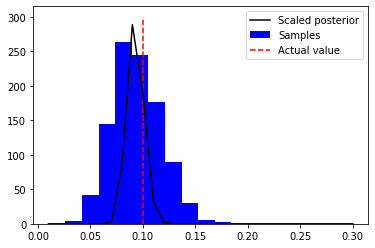

In [25]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
mod_true_prob = [x * 6 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

# Adaptive PMC ABC

In [26]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

# set threshold
abc.sampler().set_N_l(700)

# set p_acc_min
abc.sampler().set_p_acc_min(0.05)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.12649993]
epsilon=4.41021541423999
w_mean=[0.11803679]
epsilon=3.5142566781611158
w_mean=[0.1157323]
epsilon=3.0
w_mean=[0.11079684]
epsilon=2.6076809620810595
w_mean=[0.10936335]
epsilon=2.313006701244076
w_mean=[0.10570389]
epsilon=2.0976176963403033
w_mean=[0.10583894]
epsilon=1.9364916731037085
w_mean=[0.10472661]
epsilon=1.857417562100671
w_mean=[0.10403322]
epsilon=1.7748239349298849
w_mean=[0.10479502]
epsilon=1.6881943016134133
w_mean=[0.10328202]
epsilon=1.6278820596099708
w_mean=[0.10181448]
epsilon=1.5811388300841898
w_mean=[0.10196287]
epsilon=1.5491933384829668
w_mean=[0.10068855]
epsilon=1.5165750888103102
w_mean=[0.10001645]
epsilon=1.4832396974191326
w_mean=[0.10054917]
epsilon=1.449137674618944
w_mean=[0.10058947]
epsilon=1.4317821063276355
w_mean=[0.10013731]
epsilon=1.4142135623730951
w_mean=[0.09995851]
epsilon=1.3784048752090223
w_mean=[0.0996001]
epsilon=1.3601470508735443
w_mean=[0.09885654]


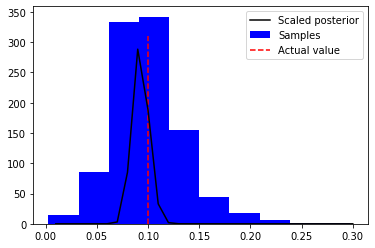

In [27]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=310, label="Actual value", color="red")
mod_true_prob = [x * 6 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

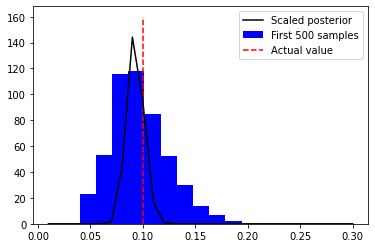

In [28]:
plt.hist(samples[:500,0], color="blue", label="First 500 samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=160, label="Actual value", color="red")
mod_true_prob = [x * 3 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

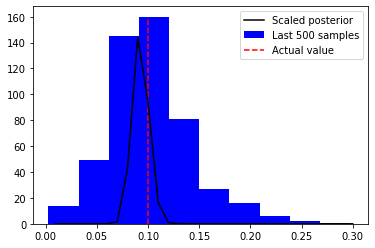

In [29]:
plt.hist(samples[500:,0], color="blue", label="Last 500 samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=160, label="Actual value", color="red")
mod_true_prob = [x * 3 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()